# Coral Reef Bleaching Data Loading and Preprocessing

This notebook provides a comprehensive pipeline for loading and preprocessing coral reef images and their corresponding bleaching masks for classification tasks.

## Dataset Structure
- **images/**: Original coral reef images (.jpg/.JPG)
- **masks_bleached/**: Binary masks indicating bleached areas (.png)
- **masks_non_bleached/**: Binary masks indicating non-bleached areas (.png)

## Task
Binary classification to identify bleached vs non-bleached parts of coral reef images.


In [2]:
# Import required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## Image Loading and Preprocessing Functions


In [3]:
def load_image(image_path, target_size=None, normalize=True):
    """Load and preprocess an image."""
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    if normalize:
        image = image.astype(np.float32) / 255.0
    
    return image

def load_mask(mask_path, target_size=None, threshold=127):
    """Load and preprocess a binary mask."""
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    if target_size:
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    
    # Convert to binary mask
    mask = (mask > threshold).astype(np.uint8)
    
    return mask

def get_image_stats(image_path):
    """Get basic statistics of an image."""
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]
    return {
        'width': width,
        'height': height,
        'aspect_ratio': width / height
    }


## Improved Patch-Based Preprocessing (Preserving Original Resolution)


In [4]:
def load_image_original_size(image_path, normalize=True):
    """Load image at original resolution without resizing."""
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if normalize:
        image = image.astype(np.float32) / 255.0
    
    return image

def load_mask_original_size(mask_path, threshold=127):
    """Load mask at original resolution without resizing."""
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Convert to binary mask
    mask = (mask > threshold).astype(np.uint8)
    
    return mask

def create_aligned_patches(image, bleached_mask, non_bleached_mask, patch_size=256, stride=None):
    """
    Create aligned patches from image and masks at original resolution.
    
    Args:
        image: Original RGB image (H, W, 3)
        bleached_mask: Binary mask for bleached areas (H, W)
        non_bleached
        _mask: Binary mask for non-bleached areas (H, W)
        patch_size: Size of square patches
        stride: Step size between patches (if None, uses patch_size for non-overlapping)
    
    Returns:
        List of dictionaries containing aligned patches and their classifications
    """
    if stride is None:
        stride = patch_size  # Non-overlapping patches by default
    
    height, width = image.shape[:2]
    patches = []
    
    # Generate grid of patch coordinates
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            # Extract patches from all three sources at the same coordinates
            image_patch = image[y:y+patch_size, x:x+patch_size]
            bleached_patch = bleached_mask[y:y+patch_size, x:x+patch_size]
            non_bleached_patch = non_bleached_mask[y:y+patch_size, x:x+patch_size]
            
            # Calculate the percentage of each class in this patch
            total_pixels = patch_size * patch_size
            bleached_pixels = np.sum(bleached_patch)
            non_bleached_pixels = np.sum(non_bleached_patch)
            
            bleached_ratio = bleached_pixels / total_pixels
            non_bleached_ratio = non_bleached_pixels / total_pixels
            background_ratio = 1.0 - bleached_ratio - non_bleached_ratio
            
            # Create patch info
            patch_info = {
                'image_patch': image_patch,
                'bleached_mask_patch': bleached_patch,
                'non_bleached_mask_patch': non_bleached_patch,
                'coordinates': (x, y),  # Top-left corner
                'bleached_ratio': bleached_ratio,
                'non_bleached_ratio': non_bleached_ratio,
                'background_ratio': background_ratio,
                'has_coral': (bleached_ratio + non_bleached_ratio) > 0.1,  # At least 10% coral
                'dominant_class': None  # Will be set below
            }
            
            # Determine dominant class (only if patch has significant coral content)
            if patch_info['has_coral']:
                if bleached_ratio > non_bleached_ratio and bleached_ratio > 0.3:
                    patch_info['dominant_class'] = 'bleached'
                elif non_bleached_ratio > bleached_ratio and non_bleached_ratio > 0.3:
                    patch_info['dominant_class'] = 'non_bleached'
                else:
                    patch_info['dominant_class'] = 'mixed'  # Mixed or unclear
            else:
                patch_info['dominant_class'] = 'background'
            
            patches.append(patch_info)
    
    return patches

print("Aligned patch extraction functions defined!")


Aligned patch extraction functions defined!


## VGG19-Compatible Processing: 224×224 Patches for Segmentation Dataset


In [5]:
# Define paths for the new segmentation dataset
SEGMENTATION_ROOT = Path("segmentation")
SEG_IMAGES_DIR = SEGMENTATION_ROOT / "images"
SEG_MASKS_DIR = SEGMENTATION_ROOT / "masks"

# Verify new dataset exists
print(f"CHECKING SEGMENTATION DATASET")
print(f"Images directory exists: {SEG_IMAGES_DIR.exists()}")
print(f"Masks directory exists: {SEG_MASKS_DIR.exists()}")

if SEG_IMAGES_DIR.exists() and SEG_MASKS_DIR.exists():
    # Count files in segmentation dataset
    seg_image_files = list(SEG_IMAGES_DIR.glob("*.jpg"))
    seg_mask_files = list(SEG_MASKS_DIR.glob("*.png"))
    
    print(f"\\nSEGMENTATION DATASET STATISTICS:")
    print(f"Images: {len(seg_image_files)}")
    print(f"Masks: {len(seg_mask_files)}")
    
    # Display sample filenames to understand naming convention
    if seg_image_files:
        print(f"\\nSample image files:")
        for i, img_file in enumerate(seg_image_files[:3]):
            print(f"  {img_file.name}")
        
    if seg_mask_files:
        print(f"\\nSample mask files:")
        for i, mask_file in enumerate(seg_mask_files[:3]):
            print(f"  {mask_file.name}")
    
    # VGG19 optimal patch size
    VGG_PATCH_SIZE = 224
    print(f"\\nTarget patch size for VGG19: {VGG_PATCH_SIZE}×{VGG_PATCH_SIZE}")
else:
    print("Segmentation dataset not found!")


CHECKING SEGMENTATION DATASET
Images directory exists: True
Masks directory exists: True
\nSEGMENTATION DATASET STATISTICS:
Images: 658
Masks: 658
\nSample image files:
  C1_Gy_PM_T3_27nov24_CGomez_corr.jpg
  C7_BC_ESa_T2_29nov24_CDaza_corr.jpg
  C9_Gy_ESa_T3_27nov24_HBenavides_corr.jpg
\nSample mask files:
  C6_BC_PSb_T2_29nov24_HBenavides_corr.png
  C8_Gr_PP_T1_30nov24_HBenavides_corr.png
  C8_Gy_EP_T2_27nov24_HBenavides_corr.png
\nTarget patch size for VGG19: 224×224


In [6]:
def create_segmentation_dataset_mapping():
    """Create mapping for the segmentation dataset with color-coded masks."""
    seg_dataset_mapping = []
    
    print("Creating segmentation dataset mapping...")
    
    for image_path in tqdm(seg_image_files, desc="Mapping files"):
        # Get base filename without extension
        base_name = image_path.stem
        
        # Find corresponding mask
        mask_candidates = [
            SEG_MASKS_DIR / f"{base_name}.png",
            SEG_MASKS_DIR / f"{base_name}.PNG"
        ]
        
        mask_path = None
        for candidate in mask_candidates:
            if candidate.exists():
                mask_path = candidate
                break
        
        if mask_path:
            seg_dataset_mapping.append({
                'image_path': str(image_path),
                'mask_path': str(mask_path),
                'base_name': base_name
            })
        else:
            print(f"No mask found for {base_name}")
    
    return seg_dataset_mapping

# Create the mapping
if SEG_IMAGES_DIR.exists():
    seg_dataset_mapping = create_segmentation_dataset_mapping()
    print(f"Successfully mapped {len(seg_dataset_mapping)} image-mask pairs")
    
    # Display sample mapping
    if seg_dataset_mapping:
        print(f"\\nSample mappings:")
        for i in range(min(3, len(seg_dataset_mapping))):
            mapping = seg_dataset_mapping[i]
            print(f"  {i+1}. Image: {Path(mapping['image_path']).name}")
            print(f"     Mask:  {Path(mapping['mask_path']).name}")
else:
    seg_dataset_mapping = []


Creating segmentation dataset mapping...


Mapping files:   0%|          | 0/658 [00:00<?, ?it/s]

Mapping files: 100%|██████████| 658/658 [00:00<00:00, 2695.66it/s]

Successfully mapped 658 image-mask pairs
\nSample mappings:
  1. Image: C1_Gy_PM_T3_27nov24_CGomez_corr.jpg
     Mask:  C1_Gy_PM_T3_27nov24_CGomez_corr.png
  2. Image: C7_BC_ESa_T2_29nov24_CDaza_corr.jpg
     Mask:  C7_BC_ESa_T2_29nov24_CDaza_corr.png
  3. Image: C9_Gy_ESa_T3_27nov24_HBenavides_corr.jpg
     Mask:  C9_Gy_ESa_T3_27nov24_HBenavides_corr.png


In [7]:
def load_color_coded_mask(mask_path, target_size=None):
    """
    Load and process color-coded mask where:
    - Red areas = bleached coral
    - Green areas = non-bleached coral  
    - Other colors = background
    """
    mask = cv2.imread(str(mask_path))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    if target_size:
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    
    # Extract color channels
    red_channel = mask[:, :, 0]
    green_channel = mask[:, :, 1]
    blue_channel = mask[:, :, 2]
    
    # Define color thresholds for detection
    red_threshold = 150
    green_threshold = 100
    
    # Create binary masks
    bleached_mask = (
        (red_channel > red_threshold) & 
        (green_channel < green_threshold) & 
        (blue_channel < green_threshold)
    ).astype(np.uint8)
    
    # Green areas (non-bleached coral): high green, low red/blue  
    non_bleached_mask = (
        (green_channel > green_threshold) & 
        (red_channel < green_threshold) & 
        (blue_channel < green_threshold)
    ).astype(np.uint8)
    
    return bleached_mask, non_bleached_mask, mask

# Test color mask loading if dataset exists
if seg_dataset_mapping:
    print(f"TESTING COLOR MASK PROCESSING")
    print("="*40)
    
    sample_mapping = seg_dataset_mapping[0]
    print(f"Testing on: {sample_mapping['base_name']}")
    
    # Load and test
    sample_image = load_image_original_size(sample_mapping['image_path'], normalize=False)
    bleached_mask, non_bleached_mask, original_mask = load_color_coded_mask(sample_mapping['mask_path'])
    
    print(f"Results:")
    print(f"Image shape: {sample_image.shape}")
    print(f"Bleached pixels: {np.sum(bleached_mask):,}")
    print(f"Non-bleached pixels: {np.sum(non_bleached_mask):,}")

print("Color mask processing functions defined!")


TESTING COLOR MASK PROCESSING
Testing on: C1_Gy_PM_T3_27nov24_CGomez_corr
Results:
Image shape: (2461, 3325, 3)
Bleached pixels: 1,976,486
Non-bleached pixels: 2,339,704
Color mask processing functions defined!


In [8]:
class UpdatedVGGCoralProcessor:
    """
    Enhanced VGG processor that:
    1. Processes all images (no image-level filtering)
    2. Creates proper train/val/test splits at image level
    3. Saves organized patches for team collaboration
    4. Filters background patches only
    """
    
    def __init__(self, seg_dataset_mapping, patch_size=224, overlap_ratio=0.5, 
                 min_coral_ratio=0.05, batch_size=10):
        self.seg_dataset_mapping = seg_dataset_mapping
        self.patch_size = patch_size
        self.overlap_ratio = overlap_ratio
        self.min_coral_ratio = min_coral_ratio
        self.batch_size = batch_size
        
        # Statistics
        self.stats = {
            'total_images': len(seg_dataset_mapping),
            'total_patches': 0,
            'coral_patches': 0,
            'bleached_patches': 0,
            'non_bleached_patches': 0,
            'background_patches': 0,
            'errors': []
        }
        
        print(f"Updated VGG Coral Processor:")
        print(f"  Total images: {len(seg_dataset_mapping)}")
        print(f"  Patch size: {patch_size}×{patch_size}")
        print(f"  Overlap: {overlap_ratio*100:.0f}%")
        print(f"  Min coral per patch: {min_coral_ratio*100:.0f}%")
    
    def analyze_image_coral_content(self, mapping):
        """Analyze coral content in an image for statistics."""
        try:
            # Load masks only (faster than loading full image)
            bleached_mask, non_bleached_mask, _ = load_color_coded_mask(mapping['mask_path'])
            
            # Calculate total coral coverage
            total_pixels = bleached_mask.size
            coral_pixels = np.sum(bleached_mask) + np.sum(non_bleached_mask)
            coral_coverage = coral_pixels / total_pixels
            
            return {
                'coral_coverage': coral_coverage,
                'bleached_pixels': np.sum(bleached_mask),
                'non_bleached_pixels': np.sum(non_bleached_mask),
                'total_pixels': total_pixels
            }
        except Exception as e:
            print(f"Error analyzing {mapping['base_name']}: {e}")
            return {'coral_coverage': 0}
    
    def analyze_all_images(self):
        """Analyze coral content in all images for statistics (no filtering)."""
        print(f"\\nAnalyzing all images...")
        
        all_images = []
        
        for mapping in tqdm(self.seg_dataset_mapping, desc="Analyzing images"):
            analysis = self.analyze_image_coral_content(mapping)
            mapping['coral_analysis'] = analysis
            all_images.append(mapping)
        
        print(f"\\nANALYSIS RESULTS:")
        print(f"  Total images: {len(all_images)}")
        print(f"  All images will be processed")
        
        return all_images
    
    def create_image_level_splits(self, all_images, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        """Create train/val/test splits at IMAGE level to prevent data leakage."""
        from sklearn.model_selection import train_test_split
        
        print(f"\\nCreating image-level splits...")
        print(f"  Available images: {len(all_images)}")
        print(f"  Target ratios - Train: {train_ratio*100:.0f}%, Val: {val_ratio*100:.0f}%, Test: {test_ratio*100:.0f}%")
        
        # Handle cases with very few images
        if len(all_images) < 3:
            print(f"Only {len(all_images)} images - using simplified split")
            if len(all_images) == 1:
                return {
                    'train': all_images,
                    'val': [],
                    'test': []
                }
            elif len(all_images) == 2:
                return {
                    'train': [all_images[0]],
                    'val': [all_images[1]],
                    'test': []
                }
        
        # Ensure splits add up to 1.0
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "Split ratios must sum to 1.0"
        
        # Adjust ratios for small datasets
        total_test_ratio = val_ratio + test_ratio
        if len(all_images) < 10:
            # For small datasets, ensure at least 1 image per split if possible
            min_images_needed = 3  # At least 1 per split
            if len(all_images) >= min_images_needed:
                # Redistribute to ensure minimum sizes
                train_images = all_images[:-2]  # All but last 2
                val_images = [all_images[-2]]   # Second to last
                test_images = [all_images[-1]]  # Last one
                
                print(f"\\nSMALL DATASET SPLIT:")
                print(f"  Train images: {len(train_images)}")
                print(f"  Validation images: {len(val_images)}")
                print(f"  Test images: {len(test_images)}")
                
                return {
                    'train': train_images,
                    'val': val_images,
                    'test': test_images
                }
        
        # Standard splitting for larger datasets
        try:
            # First split: train vs (val + test)
            train_images, temp_images = train_test_split(
                all_images, 
                test_size=total_test_ratio,
                random_state=42,
                shuffle=True
            )
            
            # Second split: val vs test (only if we have enough images)
            if len(temp_images) >= 2:
                val_test_ratio = val_ratio / total_test_ratio
                val_images, test_images = train_test_split(
                    temp_images,
                    test_size=(1 - val_test_ratio),
                    random_state=42,
                    shuffle=True
                )
            else:
                # If only 1 image in temp, assign to val
                val_images = temp_images
                test_images = []
            
            print(f"\\nSPLIT RESULTS:")
            print(f"  Train images: {len(train_images)}")
            print(f"  Validation images: {len(val_images)}")
            print(f"  Test images: {len(test_images)}")
            
            return {
                'train': train_images,
                'val': val_images, 
                'test': test_images
            }
            
        except ValueError as e:
            print(f"Splitting error: {e}")
            print("Falling back to simple assignment...")
            
            # Fallback: simple assignment
            n = len(all_images)
            train_end = max(1, int(n * train_ratio))
            val_end = min(n, train_end + max(1, int(n * val_ratio)))
            
            return {
                'train': all_images[:train_end],
                'val': all_images[train_end:val_end],
                'test': all_images[val_end:]
            }
    
    def process_split_and_save(self, split_name, images, output_dir):
        """Process images in a split and save organized patches."""
        import os
        
        split_dir = os.path.join(output_dir, split_name)
        images_dir = os.path.join(split_dir, 'images')
        masks_dir = os.path.join(split_dir, 'masks')
        
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(masks_dir, exist_ok=True)
        
        print(f"\\nProcessing {split_name} split ({len(images)} images)...")
        
        split_patches = []
        split_labels = []
        split_metadata = []
        
        for mapping in tqdm(images, desc=f"Processing {split_name}"):
            try:
                # Load image and masks
                image = load_image_original_size(mapping['image_path'], normalize=True)
                bleached_mask, non_bleached_mask, _ = load_color_coded_mask(mapping['mask_path'])
                
                # Create patches with updated logic
                patches = create_updated_vgg_compatible_patches(
                    image, bleached_mask, non_bleached_mask,
                    patch_size=self.patch_size, overlap_ratio=self.overlap_ratio
                )
                
                # Filter coral patches (background filtering only)
                coral_patches = [p for p in patches if p['has_coral'] and p['coral_ratio'] >= self.min_coral_ratio]
                
                # Save patches
                for patch_idx, patch in enumerate(coral_patches):
                    # Prepare image patch
                    image_patch = patch['image_patch']
                    if image_patch.shape != (224, 224, 3):
                        image_patch = cv2.resize(image_patch, (224, 224))
                    
                    # Convert to uint8 for saving
                    if image_patch.max() <= 1.0:
                        image_patch = (image_patch * 255).astype(np.uint8)
                    
                    # Create combined mask (red=bleached, green=non-bleached, black=background)
                    combined_mask = np.zeros((224, 224, 3), dtype=np.uint8)
                    bleached_patch = patch['bleached_mask_patch']
                    non_bleached_patch = patch['non_bleached_mask_patch']
                    
                    if bleached_patch.shape != (224, 224):
                        bleached_patch = cv2.resize(bleached_patch, (224, 224), interpolation=cv2.INTER_NEAREST)
                        non_bleached_patch = cv2.resize(non_bleached_patch, (224, 224), interpolation=cv2.INTER_NEAREST)
                    
                    combined_mask[bleached_patch == 1] = [255, 0, 0]  # Red for bleached
                    combined_mask[non_bleached_patch == 1] = [0, 255, 0]  # Green for non-bleached
                    
                    # Generate filenames
                    base_filename = f"{mapping['base_name']}_patch_{patch_idx:03d}"
                    
                    # Save files
                    cv2.imwrite(os.path.join(images_dir, f"{base_filename}.jpg"), 
                               cv2.cvtColor(image_patch, cv2.COLOR_RGB2BGR))
                    cv2.imwrite(os.path.join(masks_dir, f"{base_filename}.png"), 
                               cv2.cvtColor(combined_mask, cv2.COLOR_RGB2BGR))
                    
                    # Create label (binary: bleached=1, non-bleached=0)
                    label = 1 if patch['dominant_class'] == 'bleached' else 0
                    
                    # Store data
                    split_patches.append(image_patch)
                    split_labels.append(label)
                    split_metadata.append({
                        'filename': base_filename,
                        'original_image': mapping['base_name'],
                        'patch_coordinates': patch['coordinates'],
                        'coral_ratio': patch['coral_ratio'],
                        'bleached_ratio': patch['bleached_ratio'],
                        'non_bleached_ratio': patch['non_bleached_ratio'],
                        'dominant_class': patch['dominant_class']
                    })
                
                self.stats['total_patches'] += len(coral_patches)
                
                # Update stats
                for patch in coral_patches:
                    if patch['dominant_class'] == 'bleached':
                        self.stats['bleached_patches'] += 1
                    elif patch['dominant_class'] == 'non_bleached':
                        self.stats['non_bleached_patches'] += 1
                
                self.stats['coral_patches'] = self.stats['bleached_patches'] + self.stats['non_bleached_patches']
                
            except Exception as e:
                error_msg = f"Error processing {mapping['base_name']}: {str(e)}"
                self.stats['errors'].append(error_msg)
                print(f"Error: {error_msg}")
        
        print(f"{split_name} completed: {len(split_patches)} patches saved")
        
        return np.array(split_patches), np.array(split_labels), split_metadata

    def process_complete_pipeline(self, output_dir='updated_vgg_coral_patches'):
        """Complete pipeline: analyze, split, and save organized patches for team use."""
        import os
        import json
        
        print(f"COMPLETE PIPELINE FOR TEAM COLLABORATION (UPDATED)")
        print("="*60)
        
        # Step 1: Analyze all images (no filtering)
        all_images = self.analyze_all_images()
        
        # Step 2: Create image-level splits  
        splits = self.create_image_level_splits(all_images)
        
        # Step 3: Process and save each split
        os.makedirs(output_dir, exist_ok=True)
        
        results = {}
        
        for split_name, split_images in splits.items():
            split_patches, split_labels, split_metadata = self.process_split_and_save(
                split_name, split_images, output_dir
            )
            
            results[split_name] = {
                'patches': split_patches,
                'labels': split_labels, 
                'metadata': split_metadata,
                'num_images': len(split_images),
                'num_patches': len(split_patches)
            }
        
        # Step 4: Save metadata and statistics
        metadata_file = os.path.join(output_dir, 'dataset_info.json')
        dataset_info = {
            'processing_date': str(pd.Timestamp.now()),
            'patch_size': self.patch_size,
            'overlap_ratio': self.overlap_ratio,
            'min_coral_ratio': self.min_coral_ratio,
            'statistics': self.stats,
            'splits': {
                split: {
                    'num_images': results[split]['num_images'],
                    'num_patches': results[split]['num_patches'],
                    'image_names': [img['base_name'] for img in splits[split]]
                }
                for split in ['train', 'val', 'test']
            }
        }
        
        with open(metadata_file, 'w') as f:
            json.dump(dataset_info, f, indent=2)
        
        print(f"PIPELINE COMPLETE!")
        print(f"Output directory: {output_dir}")
        print(f"Total patches: {sum(results[split]['num_patches'] for split in results)}")
        print(f"Metadata saved: {metadata_file}")
        
        return results

print("UpdatedVGGCoralProcessor class defined!")


UpdatedVGGCoralProcessor class defined!


In [9]:
def create_updated_vgg_compatible_patches(image, bleached_mask, non_bleached_mask, 
                                  patch_size=224, overlap_ratio=0.5):
    """
    Create VGG19-compatible 224x224 patches with updated logic:
    - No 'mixed' category
    - If background + red (bleached), prefer 'bleached'
    - If background + green, prefer 'non_bleached'
    - Only 'background' if neither bleached nor non-bleached coral present
    
    Args:
        image: Original RGB image
        bleached_mask: Binary mask for bleached areas
        non_bleached_mask: Binary mask for non-bleached areas
        patch_size: Size of patches (224 for VGG19)
        overlap_ratio: Overlap ratio (0.5 = 50% overlap)
    """
    height, width = image.shape[:2]
    stride = int(patch_size * (1 - overlap_ratio))
    
    print(f"Creating Updated VGG19-compatible patches:")
    print(f"  Patch size: {patch_size}×{patch_size}")
    print(f"  Overlap: {overlap_ratio*100:.0f}% (stride={stride})")
    print(f"  Image size: {width}×{height}")
    print(f"  No 'mixed' category - prefer bleached when both present")
    
    patches = []
    
    # Calculate patch positions ensuring full coverage
    x_positions = list(range(0, width - patch_size + 1, stride))
    y_positions = list(range(0, height - patch_size + 1, stride))
    
    # Add edge patches to ensure no information loss
    if x_positions[-1] + patch_size < width:
        x_positions.append(width - patch_size)
    if y_positions[-1] + patch_size < height:
        y_positions.append(height - patch_size)
    
    print(f"  Grid: {len(x_positions)} × {len(y_positions)} = {len(x_positions) * len(y_positions)} patches")
    
    # Extract patches
    for y in y_positions:
        for x in x_positions:
            # Extract aligned patches
            image_patch = image[y:y+patch_size, x:x+patch_size]
            bleached_patch = bleached_mask[y:y+patch_size, x:x+patch_size]
            non_bleached_patch = non_bleached_mask[y:y+patch_size, x:x+patch_size]
            
            # Calculate coral content
            total_pixels = patch_size * patch_size
            bleached_pixels = np.sum(bleached_patch)
            non_bleached_pixels = np.sum(non_bleached_patch)
            coral_pixels = bleached_pixels + non_bleached_pixels
            
            # Calculate ratios
            bleached_ratio = bleached_pixels / total_pixels
            non_bleached_ratio = non_bleached_pixels / total_pixels
            coral_ratio = coral_pixels / total_pixels
            
            # Updated dominant class logic - NO 'mixed' category
            if coral_ratio > 0.05:  # At least 5% coral content
                # If both types present, prefer bleached
                if bleached_ratio > 0:
                    dominant_class = 'bleached'
                elif non_bleached_ratio > 0:
                    dominant_class = 'non_bleached'
                else:
                    # This shouldn't happen but fallback to background
                    dominant_class = 'background'
                has_coral = True
            else:
                dominant_class = 'background'
                has_coral = False
            
            patch_info = {
                'image_patch': image_patch,
                'bleached_mask_patch': bleached_patch,
                'non_bleached_mask_patch': non_bleached_patch,
                'coordinates': (x, y),
                'bleached_ratio': bleached_ratio,
                'non_bleached_ratio': non_bleached_ratio,
                'coral_ratio': coral_ratio,
                'dominant_class': dominant_class,
                'has_coral': has_coral,
                'vgg_ready': True  # Flag for VGG preprocessing
            }
            
            patches.append(patch_info)
    
    # Calculate coverage statistics
    coverage_map = np.zeros((height, width), dtype=np.uint8)
    for patch in patches:
        x, y = patch['coordinates']
        coverage_map[y:y+patch_size, x:x+patch_size] += 1
    
    coverage_pct = np.mean(coverage_map > 0) * 100
    avg_overlap = np.mean(coverage_map[coverage_map > 0])
    coral_patches = [p for p in patches if p['has_coral']]
    bleached_patches = [p for p in coral_patches if p['dominant_class'] == 'bleached']
    non_bleached_patches = [p for p in coral_patches if p['dominant_class'] == 'non_bleached']
    
    print(f"  Coverage: {coverage_pct:.1f}% of image")
    print(f"  Average overlap: {avg_overlap:.1f}x per pixel")
    print(f"  Coral patches: {len(coral_patches)}/{len(patches)} ({len(coral_patches)/len(patches)*100:.1f}%)")
    print(f"    Bleached: {len(bleached_patches)} ({len(bleached_patches)/len(patches)*100:.1f}%)")
    print(f"    Non-bleached: {len(non_bleached_patches)} ({len(non_bleached_patches)/len(patches)*100:.1f}%)")
    
    return patches

print("Updated VGG patch extraction function defined!")


Updated VGG patch extraction function defined!


In [10]:
if seg_dataset_mapping:
    print("TESTING UPDATED VGG PROCESSOR (NO FILTERING)")
    print("="*60)
    
    # Create updated processor for testing (subset of 5 images)
    test_updated_processor = UpdatedVGGCoralProcessor(
        seg_dataset_mapping=seg_dataset_mapping[:5],  # Test with 5 images
        patch_size=224,  # VGG19 standard
        overlap_ratio=0.5,  # 50% overlap for good coverage
        min_coral_ratio=0.05,  # At least 5% coral per patch
        batch_size=3  # Small batch for testing
    )
    
    # Run complete pipeline test
    print("Running updated pipeline test...")
    test_results = test_updated_processor.process_complete_pipeline(
        output_dir='test_updated_vgg_patches'
    )
    
    if test_results:
        print(f"\\nUPDATED TEST RESULTS SUMMARY:")
        total_patches = 0
        total_bleached = 0
        total_non_bleached = 0
        
        for split_name, split_data in test_results.items():
            patches = split_data['patches']
            labels = split_data['labels']
            bleached_count = np.sum(labels == 1)
            non_bleached_count = np.sum(labels == 0)
            
            print(f"  {split_name}: {split_data['num_patches']} patches from {split_data['num_images']} images")
            print(f"    Bleached: {bleached_count}")
            print(f"    Non-bleached: {non_bleached_count}")
            
            total_patches += split_data['num_patches']
            total_bleached += bleached_count
            total_non_bleached += non_bleached_count
        
        print(f"\\nOVERALL STATISTICS:")
        print(f"  Total patches: {total_patches}")
        print(f"  Total bleached: {total_bleached} ({total_bleached/total_patches*100:.1f}%)")
        print(f"  Total non-bleached: {total_non_bleached} ({total_non_bleached/total_patches*100:.1f}%)")
        print(f"  All images processed (no filtering)")
    
else:
    print("Segmentation dataset not available for testing")


TESTING UPDATED VGG PROCESSOR (NO FILTERING)
Updated VGG Coral Processor:
  Total images: 5
  Patch size: 224×224
  Overlap: 50%
  Min coral per patch: 5%
Running updated pipeline test...
COMPLETE PIPELINE FOR TEAM COLLABORATION (UPDATED)
\nAnalyzing all images...


Analyzing images: 100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


\nANALYSIS RESULTS:
  Total images: 5
  All images will be processed
\nCreating image-level splits...
  Available images: 5
  Target ratios - Train: 70%, Val: 15%, Test: 15%
\nSMALL DATASET SPLIT:
  Train images: 3
  Validation images: 1
  Test images: 1
\nProcessing train split (3 images)...


Processing train:   0%|          | 0/3 [00:00<?, ?it/s]

Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 3325×2461
  No 'mixed' category - prefer bleached when both present
  Grid: 29 × 21 = 609 patches
  Coverage: 100.0% of image
  Average overlap: 3.7x per pixel
  Coral patches: 459/609 (75.4%)
    Bleached: 364 (59.8%)
    Non-bleached: 95 (15.6%)


Processing train:  33%|███▎      | 1/3 [00:01<00:02,  1.03s/it]

Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 3213×2421
  No 'mixed' category - prefer bleached when both present
  Grid: 28 × 21 = 588 patches
  Coverage: 100.0% of image
  Average overlap: 3.8x per pixel
  Coral patches: 156/588 (26.5%)
    Bleached: 106 (18.0%)
    Non-bleached: 50 (8.5%)


Processing train:  67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]

Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 3361×2521
  No 'mixed' category - prefer bleached when both present
  Grid: 30 × 22 = 660 patches
  Coverage: 100.0% of image
  Average overlap: 3.9x per pixel
  Coral patches: 164/660 (24.8%)
    Bleached: 94 (14.2%)
    Non-bleached: 70 (10.6%)


Processing train: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


train completed: 779 patches saved
\nProcessing val split (1 images)...


Processing val: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 4233×3253
  No 'mixed' category - prefer bleached when both present
  Grid: 37 × 29 = 1073 patches
  Coverage: 100.0% of image
  Average overlap: 3.9x per pixel
  Coral patches: 30/1073 (2.8%)
    Bleached: 0 (0.0%)
    Non-bleached: 30 (2.8%)
val completed: 30 patches saved
\nProcessing test split (1 images)...


Processing test:   0%|          | 0/1 [00:00<?, ?it/s]

Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 3381×2553
  No 'mixed' category - prefer bleached when both present
  Grid: 30 × 22 = 660 patches
  Coverage: 100.0% of image
  Average overlap: 3.8x per pixel
  Coral patches: 267/660 (40.5%)
    Bleached: 98 (14.8%)
    Non-bleached: 169 (25.6%)


Processing test: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

test completed: 267 patches saved
PIPELINE COMPLETE!
Output directory: test_updated_vgg_patches
Total patches: 1076
Metadata saved: test_updated_vgg_patches/dataset_info.json
\nUPDATED TEST RESULTS SUMMARY:
  train: 779 patches from 3 images
    Bleached: 564
    Non-bleached: 215
  val: 30 patches from 1 images
    Bleached: 0
    Non-bleached: 30
  test: 267 patches from 1 images
    Bleached: 98
    Non-bleached: 169
\nOVERALL STATISTICS:
  Total patches: 1076
  Total bleached: 662 (61.5%)
  Total non-bleached: 414 (38.5%)
  All images processed (no filtering)


In [ ]:
# import random
# from scipy.ndimage import gaussian_filter
# import warnings
# warnings.filterwarnings('ignore')

# class PixelLevelAugmentation:
#     """
#     Augmentation class specifically designed for pixel-level segmentation tasks.
#     Ensures geometric transformations are applied consistently to both images and masks,
#     while photometric augmentations are only applied to images.
#     """
    
#     def __init__(self, augmentation_probability=0.5):
#         self.augmentation_probability = augmentation_probability
        
#         print("Pixel-level augmentation pipeline initialized!")
#         print("  Geometric transforms: Vertical flip, horizontal flip")
#         print("  Photometric transforms: Brightness/contrast adjustments")
#         print("  Gaussian blur: Applied separately")
    
#     def apply_gaussian_blur(self, image, sigma_range=(0.5, 1.5)):
#         """Apply mild gaussian blur to image only."""
#         sigma = random.uniform(*sigma_range)
#         # Apply blur to each channel separately
#         blurred = np.zeros_like(image)
#         for i in range(image.shape[2]):
#             blurred[:, :, i] = gaussian_filter(image[:, :, i], sigma=sigma)
#         return blurred
    
#     def augment_pair(self, image, mask, apply_blur=True):
#         """
#         Augment an image-mask pair consistently.
        
#         Args:
#             image: RGB image (H, W, 3) - uint8 or float
#             mask: Segmentation mask (H, W, 3) - color-coded
#             apply_blur: Whether to apply gaussian blur
            
#         Returns:
#             augmented_image, augmented_mask
#         """
#         # Ensure image is uint8 for albumentations
#         if image.max() <= 1.0:
#             image = (image * 255).astype(np.uint8)
        
#         # Apply geometric transformations to both image and mask
#         geometric_result = self.geometric_transforms(image=image, mask=mask)
#         aug_image = geometric_result['image']
#         aug_mask = geometric_result['mask']
        
#         # Apply photometric transformations only to image
#         if random.random() < self.augmentation_probability:
#             photometric_result = self.photometric_transforms(image=aug_image)
#             aug_image = photometric_result['image']
        
#         # Apply gaussian blur only to image
#         if apply_blur and random.random() < 0.4:  # 40% chance of blur
#             aug_image = self.apply_gaussian_blur(aug_image.astype(np.float32) / 255.0)
#             aug_image = (aug_image * 255).astype(np.uint8)
        
#         return aug_image, aug_mask
    
#     def create_augmented_dataset(self, input_dir, output_dir, num_augmentations=2):
#         """
#         Create augmented dataset from existing patches.
        
#         Args:
#             input_dir: Directory containing train/val/test splits
#             output_dir: Directory to save augmented data
#             num_augmentations: Number of augmented versions per original patch
#         """
#         import os
#         from pathlib import Path
        
#         print(f"Creating augmented dataset...")
#         print(f"  Input: {input_dir}")
#         print(f"  Output: {output_dir}")
#         print(f"  Augmentations per patch: {num_augmentations}")
        
#         os.makedirs(output_dir, exist_ok=True)
        
#         # Process each split
#         for split in ['train', 'val', 'test']:
#             split_input_dir = os.path.join(input_dir, split)
#             split_output_dir = os.path.join(output_dir, split)
            
#             if not os.path.exists(split_input_dir):
#                 print(f"  Skipping {split} - directory not found")
#                 continue
            
#             # Create output directories
#             os.makedirs(os.path.join(split_output_dir, 'images'), exist_ok=True)
#             os.makedirs(os.path.join(split_output_dir, 'masks'), exist_ok=True)
            
#             # Get all image files
#             images_dir = os.path.join(split_input_dir, 'images')
#             masks_dir = os.path.join(split_input_dir, 'masks')
            
#             image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
            
#             print(f"  Processing {split} split: {len(image_files)} patches")
            
#             total_created = 0
            
#             # Process each image-mask pair
#             for img_file in tqdm(image_files, desc=f"Augmenting {split}"):
#                 base_name = img_file.replace('.jpg', '')
#                 mask_file = base_name + '.png'
                
#                 # Load original image and mask
#                 img_path = os.path.join(images_dir, img_file)
#                 mask_path = os.path.join(masks_dir, mask_file)
                
#                 if not os.path.exists(mask_path):
#                     print(f"    Warning: No mask found for {img_file}")
#                     continue
                
#                 # Load image and mask
#                 image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 mask = cv2.imread(mask_path)
#                 mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                
#                 # Copy original files to output directory
#                 output_img_path = os.path.join(split_output_dir, 'images', img_file)
#                 output_mask_path = os.path.join(split_output_dir, 'masks', mask_file)
                
#                 cv2.imwrite(output_img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#                 cv2.imwrite(output_mask_path, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
                
#                 # Create augmented versions
#                 for aug_idx in range(num_augmentations):
#                     aug_image, aug_mask = self.augment_pair(image, mask)
                    
#                     # Save augmented versions
#                     aug_img_name = f"{base_name}_aug_{aug_idx:02d}.jpg"
#                     aug_mask_name = f"{base_name}_aug_{aug_idx:02d}.png"
                    
#                     aug_img_path = os.path.join(split_output_dir, 'images', aug_img_name)
#                     aug_mask_path = os.path.join(split_output_dir, 'masks', aug_mask_name)
                    
#                     cv2.imwrite(aug_img_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
#                     cv2.imwrite(aug_mask_path, cv2.cvtColor(aug_mask, cv2.COLOR_RGB2BGR))
                    
#                     total_created += 1
            
#             original_count = len(image_files)
#             total_patches = original_count + total_created
#             print(f"    {split}: {original_count} original + {total_created} augmented = {total_patches} total patches")
        
#         print(f"Augmented dataset creation complete!")
#         return output_dir

# print("PixelLevelAugmentation class defined!")


In [ ]:
import random
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

class PixelLevelAugmentation:
    """
    Augmentation class specifically designed for pixel-level segmentation tasks.
    Ensures geometric transformations are applied consistently to both images and masks,
    while photometric augmentations are only applied to images.
    """
    
    def __init__(self, augmentation_probability=0.5):
        self.augmentation_probability = augmentation_probability
        
        print("Pixel-level augmentation pipeline initialized!")
        print("  Geometric transforms: Vertical flip, horizontal flip")
        print("  Photometric transforms: Brightness/contrast adjustments")
        print("  Gaussian blur: Applied separately")
    
    def apply_gaussian_blur(self, image, sigma_range=(0.5, 1.5)):
        """Apply mild gaussian blur to image only."""
        sigma = random.uniform(*sigma_range)
        # Apply blur to each channel separately
        blurred = np.zeros_like(image)
        for i in range(image.shape[2]):
            blurred[:, :, i] = gaussian_filter(image[:, :, i], sigma=sigma)
        return blurred
    
    def apply_vertical_flip(self, image, mask):
        """Apply vertical flip to both image and mask."""
        return np.flipud(image), np.flipud(mask)
    
    def apply_horizontal_flip(self, image, mask):
        """Apply horizontal flip to both image and mask."""
        return np.fliplr(image), np.fliplr(mask)
    
    def adjust_brightness_contrast(self, image, brightness_factor=None, contrast_factor=None):
        """Adjust brightness and contrast of image only."""
        if brightness_factor is None:
            brightness_factor = random.uniform(0.8, 1.2)
        if contrast_factor is None:
            contrast_factor = random.uniform(0.8, 1.2)
        
        # Convert to float for calculations
        img_float = image.astype(np.float32)
        
        # Apply brightness and contrast
        img_float = img_float * contrast_factor + brightness_factor * 30
        img_float = np.clip(img_float, 0, 255)
        
        return img_float.astype(np.uint8)
    
    def add_gaussian_noise(self, image, noise_level=10):
        """Add gaussian noise to image only."""
        noise = np.random.normal(0, noise_level, image.shape)
        noisy_image = image.astype(np.float32) + noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    def augment_pair(self, image, mask, apply_blur=True):
        """
        Augment an image-mask pair consistently.
        
        Args:
            image: RGB image (H, W, 3) - uint8 or float
            mask: Segmentation mask (H, W, 3) - color-coded
            apply_blur: Whether to apply gaussian blur
            
        Returns:
            augmented_image, augmented_mask
        """
        # Ensure image is uint8
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        
        aug_image = image.copy()
        aug_mask = mask.copy()
        
        # Apply geometric transformations to both image and mask
        if random.random() < 0.5:  # 50% chance of vertical flip
            aug_image, aug_mask = self.apply_vertical_flip(aug_image, aug_mask)
            
        if random.random() < 0.3:  # 30% chance of horizontal flip
            aug_image, aug_mask = self.apply_horizontal_flip(aug_image, aug_mask)
        
        # Apply photometric transformations only to image
        if random.random() < self.augmentation_probability:
            aug_image = self.adjust_brightness_contrast(aug_image)
        
        if random.random() < 0.3:  # 30% chance of noise
            aug_image = self.add_gaussian_noise(aug_image)
        
        # Apply gaussian blur only to image
        if apply_blur and random.random() < 0.4:  # 40% chance of blur
            aug_image = self.apply_gaussian_blur(aug_image.astype(np.float32) / 255.0)
            aug_image = (aug_image * 255).astype(np.uint8)
        
        return aug_image, aug_mask

print("PixelLevelAugmentation class defined!")


PixelLevelAugmentation class defined!


In [ ]:
def create_augmented_dataset(input_dir, output_dir, num_augmentations=2, augmentation_probability=0.5):
    """
    Create augmented dataset from existing patches.
    
    Args:
        input_dir: Directory containing train/val/test splits
        output_dir: Directory to save augmented data
        num_augmentations: Number of augmented versions per original patch
        augmentation_probability: Probability of applying photometric augmentations
    """
    import os
    from pathlib import Path
    
    # Initialize augmentation pipeline
    augmenter = PixelLevelAugmentation(augmentation_probability=augmentation_probability)
    
    print(f"Creating augmented dataset...")
    print(f"  Input: {input_dir}")
    print(f"  Output: {output_dir}")
    print(f"  Augmentations per patch: {num_augmentations}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Copy dataset info if it exists
    info_file = os.path.join(input_dir, 'dataset_info.json')
    if os.path.exists(info_file):
        import shutil
        shutil.copy2(info_file, os.path.join(output_dir, 'dataset_info_original.json'))
    
    total_original = 0
    total_augmented = 0
    
    # Process each split
    for split in ['train', 'val', 'test']:
        split_input_dir = os.path.join(input_dir, split)
        split_output_dir = os.path.join(output_dir, split)
        
        if not os.path.exists(split_input_dir):
            print(f"  Skipping {split} - directory not found")
            continue
        
        # Create output directories
        os.makedirs(os.path.join(split_output_dir, 'images'), exist_ok=True)
        os.makedirs(os.path.join(split_output_dir, 'masks'), exist_ok=True)
        
        # Get all image files
        images_dir = os.path.join(split_input_dir, 'images')
        masks_dir = os.path.join(split_input_dir, 'masks')
        
        image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        
        print(f"  Processing {split} split: {len(image_files)} patches")
        
        split_created = 0
        
        # Process each image-mask pair
        for img_file in tqdm(image_files, desc=f"Augmenting {split}"):
            base_name = img_file.replace('.jpg', '')
            mask_file = base_name + '.png'
            
            # Load original image and mask
            img_path = os.path.join(images_dir, img_file)
            mask_path = os.path.join(masks_dir, mask_file)
            
            if not os.path.exists(mask_path):
                print(f"    Warning: No mask found for {img_file}")
                continue
            
            # Load image and mask
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            # Copy original files to output directory
            output_img_path = os.path.join(split_output_dir, 'images', img_file)
            output_mask_path = os.path.join(split_output_dir, 'masks', mask_file)
            
            cv2.imwrite(output_img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(output_mask_path, cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))
            
            # Create augmented versions
            for aug_idx in range(num_augmentations):
                aug_image, aug_mask = augmenter.augment_pair(image, mask)
                
                # Save augmented versions
                aug_img_name = f"{base_name}_aug_{aug_idx:02d}.jpg"
                aug_mask_name = f"{base_name}_aug_{aug_idx:02d}.png"
                
                aug_img_path = os.path.join(split_output_dir, 'images', aug_img_name)
                aug_mask_path = os.path.join(split_output_dir, 'masks', aug_mask_name)
                
                cv2.imwrite(aug_img_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                cv2.imwrite(aug_mask_path, cv2.cvtColor(aug_mask, cv2.COLOR_RGB2BGR))
                
                split_created += 1
        
        original_count = len(image_files)
        total_patches = original_count + split_created
        print(f"    {split}: {original_count} original + {split_created} augmented = {total_patches} total patches")
        
        total_original += original_count
        total_augmented += split_created
    
    print(f"Augmented dataset creation complete!")
    print(f"  Total original patches: {total_original}")
    print(f"  Total augmented patches: {total_augmented}")
    print(f"  Total patches: {total_original + total_augmented}")
    print(f"  Augmentation factor: {(total_original + total_augmented) / total_original:.1f}x")
    
    return output_dir

print("Augmented dataset creation function defined!")


Augmented dataset creation function defined!


In [14]:
# Apply augmentations to the test_updated_vgg_patches dataset
if os.path.exists('test_updated_vgg_patches'):
    print("Applying augmentations to test_updated_vgg_patches dataset...")
    
    # Create augmented dataset with 2 augmentations per patch
    augmented_dir = create_augmented_dataset(
        input_dir='test_updated_vgg_patches',
        output_dir='test_updated_vgg_patches_augmented',
        num_augmentations=2,  # Create 2 augmented versions per original
        augmentation_probability=0.6  # 60% chance of photometric augmentations
    )
    
    print(f"Augmented dataset saved to: {augmented_dir}")
    
else:
    print("test_updated_vgg_patches directory not found!")
    print("Please run the UpdatedVGGCoralProcessor first to create the patches.")


Applying augmentations to test_updated_vgg_patches dataset...
Pixel-level augmentation pipeline initialized!
  Geometric transforms: Vertical flip, horizontal flip
  Photometric transforms: Brightness/contrast adjustments
  Gaussian blur: Applied separately
Creating augmented dataset...
  Input: test_updated_vgg_patches
  Output: test_updated_vgg_patches_augmented
  Augmentations per patch: 2
  Processing train split: 779 patches


Augmenting train: 100%|██████████| 779/779 [00:07<00:00, 109.26it/s]


    train: 779 original + 1558 augmented = 2337 total patches
  Processing val split: 30 patches


Augmenting val: 100%|██████████| 30/30 [00:00<00:00, 149.54it/s]


    val: 30 original + 60 augmented = 90 total patches
  Processing test split: 267 patches


Augmenting test: 100%|██████████| 267/267 [00:01<00:00, 148.05it/s]

    test: 267 original + 534 augmented = 801 total patches
Augmented dataset creation complete!
  Total original patches: 1076
  Total augmented patches: 2152
  Total patches: 3228
  Augmentation factor: 3.0x
Augmented dataset saved to: test_updated_vgg_patches_augmented


Running augmentation demonstration...
Pixel-level augmentation pipeline initialized!
  Geometric transforms: Vertical flip, horizontal flip
  Photometric transforms: Brightness/contrast adjustments
  Gaussian blur: Applied separately


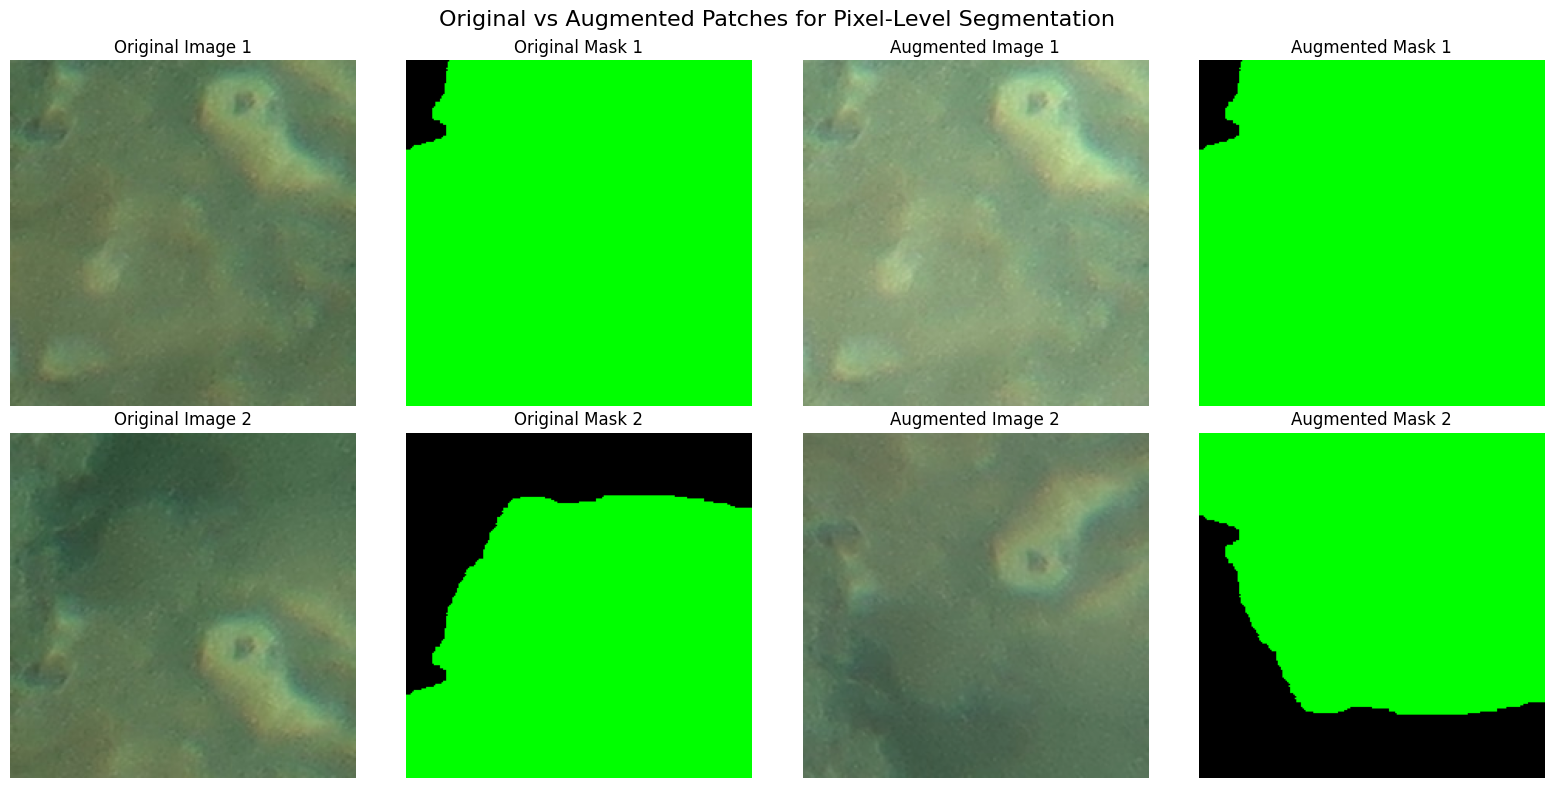

Demonstration complete!
Note: Geometric transformations (flips) are applied to both image and mask
Photometric transformations (brightness, contrast, blur) are only applied to images


In [15]:
# Demonstration: Show original vs augmented patches
def demonstrate_augmentations(input_dir, num_examples=3):
    """Show examples of original vs augmented patches."""
    import matplotlib.pyplot as plt
    import os
    
    # Initialize augmenter
    augmenter = PixelLevelAugmentation(augmentation_probability=0.8)
    
    # Get sample images from val set (smaller for demo)
    val_images_dir = os.path.join(input_dir, 'val', 'images')
    val_masks_dir = os.path.join(input_dir, 'val', 'masks')
    
    if not os.path.exists(val_images_dir):
        print("Val directory not found for demonstration")
        return
    
    image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')][:num_examples]
    
    fig, axes = plt.subplots(num_examples, 4, figsize=(16, 4*num_examples))
    fig.suptitle('Original vs Augmented Patches for Pixel-Level Segmentation', fontsize=16)
    
    for i, img_file in enumerate(image_files):
        base_name = img_file.replace('.jpg', '')
        mask_file = base_name + '.png'
        
        # Load original image and mask
        img_path = os.path.join(val_images_dir, img_file)
        mask_path = os.path.join(val_masks_dir, mask_file)
        
        if not os.path.exists(mask_path):
            continue
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Create augmented version
        aug_image, aug_mask = augmenter.augment_pair(image, mask)
        
        # Plot original image, original mask, augmented image, augmented mask
        if num_examples == 1:
            axes[0].imshow(image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(mask)
            axes[1].set_title('Original Mask')
            axes[1].axis('off')
            
            axes[2].imshow(aug_image)
            axes[2].set_title('Augmented Image')
            axes[2].axis('off')
            
            axes[3].imshow(aug_mask)
            axes[3].set_title('Augmented Mask')
            axes[3].axis('off')
        else:
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f'Original Image {i+1}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask)
            axes[i, 1].set_title(f'Original Mask {i+1}')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(aug_image)
            axes[i, 2].set_title(f'Augmented Image {i+1}')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(aug_mask)
            axes[i, 3].set_title(f'Augmented Mask {i+1}')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Demonstration complete!")
    print("Note: Geometric transformations (flips) are applied to both image and mask")
    print("Photometric transformations (brightness, contrast, blur) are only applied to images")

# Run demonstration if patches exist
if os.path.exists('test_updated_vgg_patches'):
    print("Running augmentation demonstration...")
    demonstrate_augmentations('test_updated_vgg_patches', num_examples=2)
else:
    print("Patches not found - skipping demonstration")


In [22]:
import gc
import psutil
import time

class MemoryEfficientProcessor:
    """
    Memory-efficient processor for large datasets.
    Processes images in small batches and clears memory between batches.
    """
    
    def __init__(self, seg_dataset_mapping, patch_size=224, overlap_ratio=0.5, 
                 min_coral_ratio=0.05, batch_size=5, max_patches_per_batch=1000):
        self.seg_dataset_mapping = seg_dataset_mapping
        self.patch_size = patch_size
        self.overlap_ratio = overlap_ratio
        self.min_coral_ratio = min_coral_ratio
        self.batch_size = batch_size
        self.max_patches_per_batch = max_patches_per_batch
        
        # Statistics
        self.stats = {
            'total_images': len(seg_dataset_mapping),
            'processed_images': 0,
            'total_patches': 0,
            'coral_patches': 0,
            'bleached_patches': 0,
            'non_bleached_patches': 0,
            'errors': []
        }
        
        print(f"Memory-Efficient VGG Processor Initialized:")
        print(f"  Total images: {len(seg_dataset_mapping)}")
        print(f"  Batch size: {batch_size} images")
        print(f"  Max patches per batch: {max_patches_per_batch}")
        print(f"  Patch size: {patch_size}×{patch_size}")
    
    def get_memory_usage(self):
        """Get current memory usage."""
        process = psutil.Process()
        memory_info = process.memory_info()
        return memory_info.rss / 1024 / 1024  # MB
    
    def clear_memory(self):
        """Force garbage collection to free memory."""
        gc.collect()
        
    def analyze_image_coral_content(self, mapping):
        """Analyze coral content in an image for statistics."""
        try:
            # Load masks only (faster than loading full image)
            bleached_mask, non_bleached_mask, _ = load_color_coded_mask(mapping['mask_path'])
            
            # Calculate total coral coverage
            total_pixels = bleached_mask.size
            coral_pixels = np.sum(bleached_mask) + np.sum(non_bleached_mask)
            coral_coverage = coral_pixels / total_pixels
            
            return {
                'coral_coverage': coral_coverage,
                'bleached_pixels': np.sum(bleached_mask),
                'non_bleached_pixels': np.sum(non_bleached_mask),
                'total_pixels': total_pixels
            }
        except Exception as e:
            print(f"Error analyzing {mapping['base_name']}: {e}")
            return {'coral_coverage': 0}
    
    def create_image_level_splits_efficient(self, all_images, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        """Create splits without loading images into memory."""
        from sklearn.model_selection import train_test_split
        
        print(f"Creating image-level splits...")
        print(f"  Available images: {len(all_images)}")
        print(f"  Target ratios - Train: {train_ratio*100:.0f}%, Val: {val_ratio*100:.0f}%, Test: {test_ratio*100:.0f}%")
        
        # Simple random splitting
        np.random.seed(42)
        indices = np.random.permutation(len(all_images))
        
        # Calculate split indices
        train_end = int(len(all_images) * train_ratio)
        val_end = train_end + int(len(all_images) * val_ratio)
        
        train_indices = indices[:train_end]
        val_indices = indices[train_end:val_end]
        test_indices = indices[val_end:]
        
        splits = {
            'train': [all_images[i] for i in train_indices],
            'val': [all_images[i] for i in val_indices],
            'test': [all_images[i] for i in test_indices]
        }
        
        print(f"SPLIT RESULTS:")
        print(f"  Train images: {len(splits['train'])}")
        print(f"  Validation images: {len(splits['val'])}")
        print(f"  Test images: {len(splits['test'])}")
        
        return splits
    
    def process_batch_efficiently(self, images_batch, output_dir, split_name):
        """Process a small batch of images efficiently."""
        batch_patches = []
        batch_labels = []
        batch_masks = []
        batch_metadata = []
        
        print(f"    Processing batch of {len(images_batch)} images (Memory: {self.get_memory_usage():.1f} MB)")
        
        for mapping in images_batch:
            try:
                # Load image and masks
                image = load_image_original_size(mapping['image_path'], normalize=True)
                bleached_mask, non_bleached_mask, _ = load_color_coded_mask(mapping['mask_path'])
                
                # Create patches
                patches = create_updated_vgg_compatible_patches(
                    image, bleached_mask, non_bleached_mask,
                    patch_size=self.patch_size, overlap_ratio=self.overlap_ratio
                )
                
                # Filter coral patches
                coral_patches = [p for p in patches if p['has_coral'] and p['coral_ratio'] >= self.min_coral_ratio]
                
                # Limit patches to prevent memory overflow
                if len(coral_patches) > self.max_patches_per_batch:
                    # Sort by coral ratio and take the best ones
                    coral_patches.sort(key=lambda x: x['coral_ratio'], reverse=True)
                    coral_patches = coral_patches[:self.max_patches_per_batch]
                
                # Process patches
                for patch_idx, patch in enumerate(coral_patches):
                    # Prepare image patch
                    image_patch = patch['image_patch']
                    if image_patch.shape != (224, 224, 3):
                        image_patch = cv2.resize(image_patch, (224, 224))
                    
                    # Prepare mask patches (bleached/non-bleached) and build combined color mask
                    bleached_patch = patch['bleached_mask_patch']
                    non_bleached_patch = patch['non_bleached_mask_patch']
                    if bleached_patch.shape != (224, 224):
                        bleached_patch = cv2.resize(bleached_patch, (224, 224), interpolation=cv2.INTER_NEAREST)
                        non_bleached_patch = cv2.resize(non_bleached_patch, (224, 224), interpolation=cv2.INTER_NEAREST)
                    combined_mask = np.zeros((224, 224, 3), dtype=np.uint8)
                    combined_mask[bleached_patch == 1] = [255, 0, 0]
                    combined_mask[non_bleached_patch == 1] = [0, 255, 0]
                    
                    # Convert to uint8 for saving
                    if image_patch.max() <= 1.0:
                        image_patch = (image_patch * 255).astype(np.uint8)
                    
                    # Create label
                    label = 1 if patch['dominant_class'] == 'bleached' else 0
                    
                    # Store for this batch only
                    batch_patches.append(image_patch)
                    batch_masks.append(combined_mask)
                    batch_labels.append(label)
                    batch_metadata.append({
                        'filename': f"{mapping['base_name']}_patch_{patch_idx:03d}",
                        'original_image': mapping['base_name'],
                        'patch_coordinates': patch['coordinates'],
                        'coral_ratio': patch['coral_ratio'],
                        'bleached_ratio': patch['bleached_ratio'],
                        'non_bleached_ratio': patch['non_bleached_ratio'],
                        'dominant_class': patch['dominant_class']
                    })
                
                # Update stats
                self.stats['processed_images'] += 1
                self.stats['total_patches'] += len(coral_patches)
                
                for patch in coral_patches:
                    if patch['dominant_class'] == 'bleached':
                        self.stats['bleached_patches'] += 1
                    elif patch['dominant_class'] == 'non_bleached':
                        self.stats['non_bleached_patches'] += 1
                
                # Clear memory after each image
                del image, bleached_mask, non_bleached_mask, patches, coral_patches
                
            except Exception as e:
                error_msg = f"Error processing {mapping['base_name']}: {str(e)}"
                self.stats['errors'].append(error_msg)
                print(f"      Error: {error_msg}")
        
        # Force garbage collection
        self.clear_memory()
        
        print(f"    Batch completed: {len(batch_patches)} patches (Memory: {self.get_memory_usage():.1f} MB)")
        
        return (np.array(batch_patches) if batch_patches else np.array([]),
                np.array(batch_labels) if batch_labels else np.array([]),
                np.array(batch_masks) if batch_masks else np.array([]),
                batch_metadata)

print("MemoryEfficientProcessor class defined!")


MemoryEfficientProcessor class defined!


In [25]:
def process_split_and_save_efficiently(processor, split_name, images, output_dir):
    """Process images in a split and save patches directly to disk (memory efficient)."""
    import os
    from pathlib import Path
    
    split_dir = os.path.join(output_dir, split_name)
    images_dir = os.path.join(split_dir, 'images')
    masks_dir = os.path.join(split_dir, 'masks')
    
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)
    
    print(f"Processing {split_name} split ({len(images)} images)...")
    
    total_saved_patches = 0
    split_metadata = []
    
    # Process images in small batches
    for i in range(0, len(images), processor.batch_size):
        batch_end = min(i + processor.batch_size, len(images))
        batch_images = images[i:batch_end]
        batch_num = (i // processor.batch_size) + 1
        total_batches = (len(images) + processor.batch_size - 1) // processor.batch_size
        
        print(f"  Batch {batch_num}/{total_batches}: Processing {len(batch_images)} images")
        
        # Process batch and get patches in memory temporarily
        batch_patches, batch_labels, batch_masks, batch_meta = processor.process_batch_efficiently(
            batch_images, output_dir, split_name
        )
        
        # Save patches immediately and free memory
        if len(batch_patches) > 0:
            for patch_idx, (patch, label, mask_img, meta) in enumerate(zip(batch_patches, batch_labels, batch_masks, batch_meta)):
                # Create filenames
                base_filename = meta['filename']
                
                # Save image patch
                img_path = os.path.join(images_dir, f"{base_filename}.jpg")
                cv2.imwrite(img_path, cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))
                
                # Save mask patch (already combined color mask)
                mask_path = os.path.join(masks_dir, f"{base_filename}.png")
                cv2.imwrite(mask_path, cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))
                
                # Store metadata
                split_metadata.append(meta)
                total_saved_patches += 1
        
        # Clear batch data from memory immediately
        del batch_patches, batch_labels, batch_meta
        processor.clear_memory()
        
        print(f"    Batch {batch_num} completed: {len(batch_patches) if 'batch_patches' in locals() else 0} patches saved")
    
    print(f"  {split_name} completed: {total_saved_patches} patches saved")
    
    return total_saved_patches, split_metadata

def process_full_dataset_efficiently(seg_dataset_mapping, output_dir='full_vgg_coral_patches_efficient', 
                                    batch_size=3, max_patches_per_batch=500):
    """
    Process the full 658-image dataset efficiently without memory overflow.
    """
    import os
    import json
    import time
    
    print(f"MEMORY-EFFICIENT PROCESSING OF FULL DATASET")
    print("="*60)
    print(f"Total images to process: {len(seg_dataset_mapping)}")
    print(f"Batch size: {batch_size} images per batch")
    print(f"Max patches per batch: {max_patches_per_batch}")
    
    start_time = time.time()
    
    # Initialize memory-efficient processor
    processor = MemoryEfficientProcessor(
        seg_dataset_mapping=seg_dataset_mapping,
        patch_size=224,
        overlap_ratio=0.5,
        min_coral_ratio=0.05,
        batch_size=batch_size,
        max_patches_per_batch=max_patches_per_batch
    )
    
    # Step 1: Create image-level splits efficiently
    print(f"Memory before splitting: {processor.get_memory_usage():.1f} MB")
    splits = processor.create_image_level_splits_efficient(seg_dataset_mapping)
    
    # Step 2: Process and save each split
    os.makedirs(output_dir, exist_ok=True)
    
    results = {}
    total_patches_all_splits = 0
    
    for split_name, split_images in splits.items():
        print(f"Memory before {split_name}: {processor.get_memory_usage():.1f} MB")
        
        num_patches, metadata = process_split_and_save_efficiently(
            processor, split_name, split_images, output_dir
        )
        
        results[split_name] = {
            'num_images': len(split_images),
            'num_patches': num_patches,
            'metadata': metadata
        }
        
        total_patches_all_splits += num_patches
        
        print(f"Memory after {split_name}: {processor.get_memory_usage():.1f} MB")
        processor.clear_memory()
    
    # Step 3: Save final metadata and statistics
    processing_time = time.time() - start_time
    
    metadata_file = os.path.join(output_dir, 'dataset_info.json')
    dataset_info = {
        'processing_date': str(pd.Timestamp.now()),
        'processing_time_minutes': processing_time / 60,
        'patch_size': processor.patch_size,
        'overlap_ratio': processor.overlap_ratio,
        'min_coral_ratio': processor.min_coral_ratio,
        'batch_size': batch_size,
        'max_patches_per_batch': max_patches_per_batch,
        'statistics': processor.stats,
        'splits': {
            split: {
                'num_images': results[split]['num_images'],
                'num_patches': results[split]['num_patches'],
                'image_names': [img['base_name'] for img in splits[split]]
            }
            for split in ['train', 'val', 'test']
        }
    }
    
    with open(metadata_file, 'w') as f:
        json.dump(dataset_info, f, indent=2)
    
    print(f"EFFICIENT PROCESSING COMPLETE!")
    print(f"  Processing time: {processing_time/60:.1f} minutes")
    print(f"  Output directory: {output_dir}")
    print(f"  Total patches: {total_patches_all_splits:,}")
    print(f"  Images processed: {processor.stats['processed_images']}/{processor.stats['total_images']}")
    print(f"  Errors: {len(processor.stats['errors'])}")
    print(f"  Final memory usage: {processor.get_memory_usage():.1f} MB")
    print(f"  Metadata saved: {metadata_file}")
    
    return results

print("Efficient processing functions defined!")


Efficient processing functions defined!


In [26]:
# Process the full 658-image dataset efficiently
if seg_dataset_mapping and len(seg_dataset_mapping) > 0:
    print(f"Starting memory-efficient processing of {len(seg_dataset_mapping)} images...")
    
    # Check available memory
    import psutil
    available_memory = psutil.virtual_memory().available / 1024 / 1024 / 1024  # GB
    print(f"Available system memory: {available_memory:.1f} GB")
    
    # Adjust batch size based on available memory
    if available_memory > 8:
        batch_size = 5
        max_patches = 800
    elif available_memory > 4:
        batch_size = 3
        max_patches = 500
    else:
        batch_size = 2
        max_patches = 300
    
    print(f"Using batch_size={batch_size}, max_patches_per_batch={max_patches}")
    
    try:
        # Run the efficient processing
        results = process_full_dataset_efficiently(
            seg_dataset_mapping=seg_dataset_mapping,
            output_dir='full_vgg_coral_patches_efficient',
            batch_size=batch_size,
            max_patches_per_batch=max_patches
        )
        
        if results:
            print(f"SUCCESS! Dataset processing completed:")
            total_patches = sum(results[split]['num_patches'] for split in results)
            total_images = sum(results[split]['num_images'] for split in results)
            
            print(f"  Total images processed: {total_images}")
            print(f"  Total patches created: {total_patches:,}")
            
            for split_name, split_data in results.items():
                print(f"  {split_name}: {split_data['num_images']} images → {split_data['num_patches']} patches")
        
    except Exception as e:
        print(f"Error during processing: {e}")
        print("Try reducing batch_size or max_patches_per_batch if memory issues persist")
        import traceback
        traceback.print_exc()

else:
    print("No segmentation dataset mapping found!")
    print("Please ensure the segmentation dataset is loaded first.")


Starting memory-efficient processing of 658 images...
Available system memory: 2.9 GB
Using batch_size=2, max_patches_per_batch=300
MEMORY-EFFICIENT PROCESSING OF FULL DATASET
Total images to process: 658
Batch size: 2 images per batch
Max patches per batch: 300
Memory-Efficient VGG Processor Initialized:
  Total images: 658
  Batch size: 2 images
  Max patches per batch: 300
  Patch size: 224×224
Memory before splitting: 467.6 MB
Creating image-level splits...
  Available images: 658
  Target ratios - Train: 70%, Val: 15%, Test: 15%
SPLIT RESULTS:
  Train images: 460
  Validation images: 98
  Test images: 100
Memory before train: 467.8 MB
Processing train split (460 images)...
  Batch 1/230: Processing 2 images
    Processing batch of 2 images (Memory: 467.8 MB)
Creating Updated VGG19-compatible patches:
  Patch size: 224×224
  Overlap: 50% (stride=112)
  Image size: 4261×3181
  No 'mixed' category - prefer bleached when both present
  Grid: 38 × 28 = 1064 patches
  Coverage: 100.0% o

# Next Steps: Model Training

The preprocessed data is now ready for training! To use this data:

1. **Create a new training notebook/script** with PyTorch DataLoader
2. **For on-the-fly augmentation**, use this structure in your training code:

```python
# In your new training notebook:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2
import os
import json
import numpy as np

class CoralPatchDataset(Dataset):
    def __init__(self, patches_dir='full_vgg_coral_patches_efficient', split='train', transform=None):
        self.patches_dir = patches_dir
        self.split = split
        self.transform = transform
        
        # Load dataset info
        info_path = os.path.join(patches_dir, 'dataset_info.json')
        with open(info_path, 'r') as f:
            self.dataset_info = json.load(f)
        
        # Get file paths for this split
        images_dir = os.path.join(patches_dir, split, 'images')
        masks_dir = os.path.join(patches_dir, split, 'masks')
        
        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        
        # Load all image files for this split
        for img_file in sorted(os.listdir(images_dir)):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(images_dir, img_file)
                mask_path = os.path.join(masks_dir, img_file.replace('.jpg', '.png'))
                
                # Determine label from mask (you can also store this in metadata)
                mask = cv2.imread(mask_path)
                # Simple label extraction: check if mask has more red (bleached) or green (non-bleached)
                red_pixels = np.sum(mask[:,:,2] > 150)  # Red channel
                green_pixels = np.sum(mask[:,:,1] > 150)  # Green channel
                label = 1 if red_pixels > green_pixels else 0  # 1=bleached, 0=non-bleached
                
                self.image_paths.append(img_path)
                self.mask_paths.append(mask_path)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations (only during training)
        if self.transform and self.split == 'train':
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Just normalize for val/test
            image = image.astype(np.float32) / 255.0
            
        return image, mask, self.labels[idx]

# Use Albumentations for efficient on-the-fly augmentation
train_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.ToTensorV2()
])

val_test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.ToTensorV2()
])

# Create datasets and dataloaders
train_dataset = CoralPatchDataset('full_vgg_coral_patches_efficient', 'train', train_transform)
val_dataset = CoralPatchDataset('full_vgg_coral_patches_efficient', 'val', val_test_transform)
test_dataset = CoralPatchDataset('full_vgg_coral_patches_efficient', 'test', val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Dataset loaded: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test patches")
```
